In [1]:
!git clone https://github.com/ruizheliUOA/Anchored_Bias_GPT2.git

Cloning into 'Anchored_Bias_GPT2'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 6), reused 15 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 297.42 KiB | 669.00 KiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
%cd Anchored_Bias_GPT2

/content/Anchored_Bias_GPT2


In [3]:
%ls

demos/  figs/  gpt2_small_data/  LICENSE  README.md  requirements.txt


In [4]:
!pip install -r ./requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 20.5 MB/s eta 0:00:00
  

In [5]:
import torch as t
from fancy_einsum import einsum
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer
from rich import print as rprint
import json

In [6]:
t.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


In [7]:
gpt2_small_model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

# Get the default device used
device: t.device = utils.get_device()
print(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
cuda


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../total_dataset.csv', encoding='utf-8-sig')

In [9]:
import pandas as pd
import json

# 'explanation'과 'grade' 컬럼 제거
df_filtered = df.drop(columns=['explanation', 'grade'], errors='ignore')

# 필요한 정보만 추출해서 JSON 형식으로 변환
json_list = []
for _, row in df_filtered.iterrows():
    # 문장 생성
    context = row['context']
    question = row['problem']
    sentence = f"Questions:{question} Context:{context} Answer Choices: 1: {row['choice_1']} 2: {row['choice_2']} 3: {row['choice_3']} 4: {row['choice_4']} 5: {row['choice_5']} Answer:"

    # 라벨 결정 (1 , 2 , ...)
    label = row['answer']

    json_list.append({
        "sentence": sentence,
        "label": label
    })

# 상위 몇 개 항목만 미리보기로 출력
json_list[:5]


[{'sentence': 'Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:The elements any particular animal needs are relatively predictable. They are predictable based on the past: what an animal’s ancestors needed is likely to be what that animal also needs. [BLANK], therefore, can be hardwired. Consider sodium (Na). The bodies of terrestrial vertebrates, including those of mammals, tend to have a concentration of sodium nearly fifty times that of the primary producers on land, plants. This is, in part, because vertebrates evolved in the sea and so evolved cells dependent upon the ingredients that were common in the sea, including sodium. To remedy the difference between their needs for sodium and that available in plants, herbivores can eat fifty times more plant material than they otherwise need (and eliminate the excess). Or they can seek out other sources of sodiu

In [10]:
data_samples = json_list

anchored_data = [data['sentence'] for data in data_samples[1:2]]
# 보기들을 문자열로 준비: " 1", " 2", ..., " 5"
answers = [f" {i}" for i in range(1, 6)]

# 출력 확인
rprint(anchored_data[0])
rprint(tuple(answers))  # (' 1', ' 2', ' 3', ' 4', ' 5')

# 토큰화 및 transpose (보기 수 x seq_len → seq_len x 보기 수)
answer_tokens = t.concat([
    gpt2_small_model.to_tokens(choice, prepend_bos=False).T for choice in answers
], dim=1)  # dim=1로 붙여야 shape이 (seq_len, 5)

# 출력 결과
rprint(answer_tokens[0])
print(len(data_samples))
print(answer_tokens.shape[1])  # 5개 보기


Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article,
and explain in detail why the words are appropriate Context:Some people argue that there is a single, logically 
consistent concept known as reading that can be neatly set apart from everything else people do with books. Is 
reading really that simple? The most productive way to think about reading is as [BLANK] owing to family 
resemblances, as Ludwig Wittgenstein used the phrase, without having in common a single defining trait. 
Consequently, efforts to distinguish reading from nonreading are destined to fail because there is no agreement on 
what qualifies as reading in the first place. The more one tries to figure out where the border lies between 
reading and not-reading, the more edge cases will be found to stretch the term’s flexible boundaries. Thus, it is 
worth attempting to collect together these exceptional forms of reading into a single forum, one highlighting the 
challenges faced by anyone wishing to establish the boundaries where reading begins and ends. The attempt moves 
toward an understanding of reading as a spectrum that is expansive enough to accommodate the distinct reading 
activities. Answer Choices: 1: an active process that encourages flexible thinking 2: a loosely related set of 
behaviors that belong together 3: an acquired skill and not something that one is born with 4: a collection of 
activities in which many other opinions interact 5: a safe territory to relieve a sense of separation from the 
world Answer:

(' 1', ' 2', ' 3', ' 4', ' 5')

tensor([352, 362, 513, 604, 642], device='cuda:0')

180
5


In [11]:
tokens = gpt2_small_model.to_tokens(anchored_data[0], prepend_bos=True)
original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

In [12]:
final_logits = original_logits[0, -1]
probs = final_logits.softmax(dim=-1)
top_probs, top_indices = probs.topk(10)  # 상위 10개 예측
top_tokens = [gpt2_small_model.to_string(i.item()) for i in top_indices]
for i in range(10):
    print(f"{i+1}. {top_tokens[i]} ({top_probs[i].item():.4f})")


1.  1 (0.0633)
2.  The (0.0592)
3.  2 (0.0382)
4.  A (0.0263)
5.  I (0.0207)
6.  There (0.0192)
7.  This (0.0182)
8.  6 (0.0170)
9. 1 (0.0166)
10.  5 (0.0162)


In [13]:
# 입력 문장 토큰화 + 모델 실행
tokens = gpt2_small_model.to_tokens(anchored_data[0], prepend_bos=True)
original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

# 마지막 위치의 로짓 → 확률
final_logits = original_logits[0, -1]
probs = final_logits.softmax(dim=-1)

# 각 선택지(" 1" ~ " 5")의 첫 토큰 ID
answer_ids = [gpt2_small_model.to_tokens(ans, prepend_bos=False)[0, 0].item() for ans in answers]

# 각 보기의 확률 출력
print("=== Model Probabilities for Each Answer Choice ===")
for i, aid in enumerate(answer_ids):
    print(f"Choice {i+1} ({answers[i].strip()}): {probs[aid].item():.4f}")


=== Model Probabilities for Each Answer Choice ===
Choice 1 (1): 0.0633
Choice 2 (2): 0.0382
Choice 3 (3): 0.0148
Choice 4 (4): 0.0124
Choice 5 (5): 0.0162


전체 TEST


In [14]:
import json
import torch as t
from collections import Counter
from transformer_lens import HookedTransformer

# 모델 로드
model = HookedTransformer.from_pretrained("gpt2-small")

choices = [f" {i}" for i in range(1, 6)]
choice_token_ids = [model.to_tokens(c, prepend_bos=False)[0, 0].item() for c in choices]

correct = 0
results = []

with t.no_grad():
    for sample in json_list:
        sentence = sample["sentence"]
        label = int(sample["label"])
        tokens = model.to_tokens(sentence, prepend_bos=True)
        logits, _ = model.run_with_cache(tokens)
        probs = logits[0, -1].softmax(dim=-1)
        choice_probs = [probs[i].item() for i in choice_token_ids]
        pred = int(t.tensor(choice_probs).argmax().item()) + 1
        correct += int(pred == label)
        results.append(pred)

accuracy = correct / len(json_list)
counts = Counter(results)
distribution = {str(i): round(counts[i] / len(json_list) * 100, 2) for i in range(1, 6)}

print("Accuracy:", round(accuracy * 100, 2), "%")
print("Choice distribution:", distribution)


Loaded pretrained model gpt2-small into HookedTransformer
Accuracy: 34.44 %
Choice distribution: {'1': 91.67, '2': 8.33, '3': 0.0, '4': 0.0, '5': 0.0}


In [15]:
print(len(results))

180


In [16]:
layers_ls = [i for i in range(gpt2_small_model.cfg.n_layers)]

In [17]:
layers_ls

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Citation
https://github.com/ruizheliUOA/Anchored_Bias_GPT2
```
@article{li2024anchored,
  title={Anchored Answer: Unravelling Positional Bias in GPT-2's Multiple-Choice Questions},
  author={Li, Ruizhe and Gao, Yanjun},
  journal={arXiv preprint arXiv:2405.03205},
  year={2024}
}
```

In [18]:
def mlp_lens_detector(model, model_cache, anchored_pos, correct_pos, layer_index):
    sent_weighted_values = model_cache["mlp_out", layer_index]
    correct_pos_mlp_lens = einsum("i,i->", model.W_U[:, correct_pos], model.ln_final(sent_weighted_values[0, -1, :])) + model.b_U[correct_pos] # logit lens for correct pos
    anchored_pos_mlp_lens = einsum("i,i->", model.W_U[:, anchored_pos], model.ln_final(sent_weighted_values[0, -1, :])) + model.b_U[anchored_pos] # logit lens for anchored pos
    print(f"Correct pos mlp lens: {correct_pos_mlp_lens}")
    print(f"Anchored pos mlp lens: {anchored_pos_mlp_lens}")

    return (anchored_pos_mlp_lens - correct_pos_mlp_lens).item(), correct_pos_mlp_lens.item(), anchored_pos_mlp_lens.item()

In [19]:
def coefficient_dim_contribution_detector(model, model_cache, anchored_pos, correct_pos, layer_index, gap_threshold=4):
    coefficients_final_pos = model_cache["post", layer_index].squeeze(0)[-1]
    W_out = model.W_out[layer_index]

    contributions_ls = []
    for i in range(coefficients_final_pos.shape[0]):
        coefficient_abs = t.abs(coefficients_final_pos[i])
        value_2_norm = t.linalg.vector_norm(W_out[i], ord=2)
        contributions_ls.append(coefficient_abs * value_2_norm)

    contributions = t.stack(contributions_ls)

    topk_contributions, topk_indices = t.topk(contributions, k=10, largest=True)

    topk_correct_pos_contributions = [] # abs value of correct pos contribution
    for i in range(topk_indices.shape[0]):
        correct_pos_contribution = einsum("d_model, d_model->", model.W_U[:, correct_pos], model.ln_final(coefficients_final_pos[topk_indices[i]] * W_out[topk_indices[i]] + model.b_out[layer_index])) + model.b_U[correct_pos]
        topk_correct_pos_contributions.append(correct_pos_contribution)

    topk_anchor_pos_contributions = [] # abs value of anchored pos contribution
    for i in range(topk_indices.shape[0]):
        anchor_pos_contribution = einsum("d_model, d_model->", model.W_U[:, anchored_pos], model.ln_final(coefficients_final_pos[topk_indices[i]] * W_out[topk_indices[i]] + model.b_out[layer_index])) + model.b_U[anchored_pos]
        topk_anchor_pos_contributions.append(anchor_pos_contribution)

    topk_words_ls = [] # visualize top k words stored in model's W_out based on specific dimension
    for i in range(topk_indices.shape[0]):
        per_value_words = []
        value_unembed = einsum("d_model, d_model d_vocab-> d_vocab", model.ln_final(W_out[topk_indices[i]] + model.b_out[layer_index]), model.W_U) + model.b_U
        prob_unembed = value_unembed.softmax(dim=-1)
        prob_unembed_values, prob_unembed_indices = prob_unembed.sort(descending=True)
        for j in range(20):
            per_value_words.append(model.to_string(prob_unembed_indices[j]))

        topk_words_ls.append(per_value_words)

    diff_contributions = t.stack(topk_anchor_pos_contributions) - t.stack(topk_correct_pos_contributions)
    large_gap_indices = t.where(diff_contributions > gap_threshold)[0]
    large_gap_topk_indices = topk_indices[large_gap_indices]

    large_gap_topk_words_ls = [topk_words_ls[i] for i in large_gap_indices]

    return large_gap_topk_indices, diff_contributions[large_gap_indices].tolist(), large_gap_topk_words_ls, topk_contributions.tolist(), topk_indices.tolist(), topk_correct_pos_contributions, topk_anchor_pos_contributions

In [20]:
def fix_mlp(model, gap_dim, layer_index, anchored_pos, correct_pos, alpha_1 = 1, alpha_2 = 8): # follow Value_dim = Value_dim - alpha_1 * anchord_unemebed + alpha_2 * correct_unembed
    original_W_out = model.blocks[layer_index].mlp.W_out.clone()
    model.blocks[layer_index].mlp.W_out[gap_dim, :] = model.blocks[layer_index].mlp.W_out[gap_dim, :] - alpha_1 * model.W_U[:, anchored_pos] + alpha_2 * model.W_U[:, correct_pos]
    return original_W_out, model

In [21]:
def prediction_compare(modified_model, tokens, original_logits, correct_pos):
    modified_logits, modified_gpt2_cache = modified_model.run_with_cache(tokens)
    modified_final_pos_probs = modified_logits.squeeze(0)[-1].softmax(dim=-1)
    modified_final_pos_values, modified_final_pos_indices = modified_final_pos_probs.sort(descending=True)


    top_20_words_modified = []
    for i in range(20):
        top_20_words_modified.append(modified_model.to_string(modified_final_pos_indices[i]))
    modified_correct_prob = modified_final_pos_probs[correct_pos]


    original_final_pos_probs = original_logits.squeeze(0)[-1].softmax(dim=-1)
    original_final_pos_values, original_final_pos_indices = original_final_pos_probs.sort(descending=True)
    top_20_words_original = []
    for i in range(20):
        top_20_words_original.append(modified_model.to_string(original_final_pos_indices[i]))

    original_correct_prob = original_final_pos_probs[correct_pos]

    return modified_final_pos_indices[0].item() == correct_pos, modified_final_pos_values[0], original_final_pos_values[0], top_20_words_modified, top_20_words_original, modified_correct_prob, original_correct_prob

## MLP layer & dim: Check Anchor Bias

각 layer 별 확인 후 MLP 수정 진행 => modified - original 비교

이후 원복

In [22]:
# 2번과 1번(Anchor) 비교

sample = [s for s in json_list if int(s["label"]) in [2]][0]

sentence = sample["sentence"]
label = int(sample["label"])
answers = [f" {i}" for i in range(1, 6)]
correct_token = gpt2_small_model.to_tokens(answers[label - 1], prepend_bos=False)[0, 0].item()
anchor_token = gpt2_small_model.to_tokens(answers[0], prepend_bos=False)[0, 0].item()

tokens = gpt2_small_model.to_tokens(sentence, prepend_bos=True)
original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

print(f"Sent: {gpt2_small_model.to_string(tokens)}")
print(label)

for layer_index in layers_ls[::-1]:

    print(f"Layer: {layer_index}")

    mlp_lens, correct_pos_lens, anchored_pos_lens = mlp_lens_detector(gpt2_small_model, gpt2_cache, answer_tokens[0][0].item(), answer_tokens[0][1].item(), layer_index)

    print(f"MLP logit difference at layer {layer_index}: {mlp_lens}")

    large_gap_topk_indices, diff_contributions, large_gap_topk_words_ls, topk_contributions, topk_indices, took_correct_pos_contributions, topk_anchor_pos_contributions = coefficient_dim_contribution_detector(gpt2_small_model, gpt2_cache, answer_tokens[0][0].item(), answer_tokens[0][1].item(), layer_index)

    print(f"Large diff dimensions at layer {layer_index} are {[i.item() for i in large_gap_topk_indices]}")
    print(f"Top 20 words for large diff dimensions at layer {layer_index} are {large_gap_topk_words_ls}")
    print(f"Diff logit contributions for large diff dimensions at layer {layer_index} are {diff_contributions}")

    if len(large_gap_topk_indices) != 0:

        original_W_out, modified_model = fix_mlp(gpt2_small_model, large_gap_topk_indices[0], layer_index, answer_tokens[0][0].item(), answer_tokens[0][1].item())

        prediction_result, modified_final_pos_top1_value, original_final_pos_top1_value, top_20_words_modified, top_20_words_original, modified_correct_prob, original_correct_prob = prediction_compare(modified_model, tokens.squeeze(0), original_logits, answer_tokens[0][1].item())


        print(f"Modified prediction result is {prediction_result}, modified next token prob is {modified_final_pos_top1_value}, original next token prob is {original_final_pos_top1_value}")
        print(f"Top 20 words for modified model are {top_20_words_modified}")
        print(f"Top 20 words for original model are {top_20_words_original}")
        print("--------------------------------------------------------------------------------------------------------------------")

        gpt2_small_model.blocks[layer_index].mlp.W_out[large_gap_topk_indices[0], :] = original_W_out[large_gap_topk_indices[0], :]

Sent: ['<|endoftext|>Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:Some people argue that there is a single, logically consistent concept known as reading that can be neatly set apart from everything else people do with books. Is reading really that simple? The most productive way to think about reading is as [BLANK] owing to family resemblances, as Ludwig Wittgenstein used the phrase, without having in common a single defining trait. Consequently, efforts to distinguish reading from nonreading are destined to fail because there is no agreement on what qualifies as reading in the first place. The more one tries to figure out where the border lies between reading and not-reading, the more edge cases will be found to stretch the term’s flexible boundaries. Thus, it is worth attempting to collect together these exceptional forms of reading into a single forum, 

In [23]:
# 3번과 1번(Anchor) 비교

sample = [s for s in json_list if int(s["label"]) in [3]][0]

sentence = sample["sentence"]
label = int(sample["label"])
answers = [f" {i}" for i in range(1, 6)]
correct_token = gpt2_small_model.to_tokens(answers[label - 1], prepend_bos=False)[0, 0].item()
anchor_token = gpt2_small_model.to_tokens(answers[0], prepend_bos=False)[0, 0].item()

tokens = gpt2_small_model.to_tokens(sentence, prepend_bos=True)
original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

print(f"Sent: {gpt2_small_model.to_string(tokens)}")
print(label)

for layer_index in layers_ls[::-1]:

    print(f"Layer: {layer_index}")

    mlp_lens, correct_pos_lens, anchored_pos_lens = mlp_lens_detector(gpt2_small_model, gpt2_cache, answer_tokens[0][0].item(), answer_tokens[0][2].item(), layer_index)

    print(f"MLP logit difference at layer {layer_index}: {mlp_lens}")

    large_gap_topk_indices, diff_contributions, large_gap_topk_words_ls, topk_contributions, topk_indices, took_correct_pos_contributions, topk_anchor_pos_contributions = coefficient_dim_contribution_detector(gpt2_small_model, gpt2_cache, answer_tokens[0][0].item(), answer_tokens[0][2].item(), layer_index)

    print(f"Large diff dimensions at layer {layer_index} are {[i.item() for i in large_gap_topk_indices]}")
    print(f"Top 20 words for large diff dimensions at layer {layer_index} are {large_gap_topk_words_ls}")
    print(f"Diff logit contributions for large diff dimensions at layer {layer_index} are {diff_contributions}")

    if len(large_gap_topk_indices) != 0:

        original_W_out, modified_model = fix_mlp(gpt2_small_model, large_gap_topk_indices[0], layer_index, answer_tokens[0][0].item(), answer_tokens[0][2].item())

        prediction_result, modified_final_pos_top1_value, original_final_pos_top1_value, top_20_words_modified, top_20_words_original, modified_correct_prob, original_correct_prob = prediction_compare(modified_model, tokens.squeeze(0), original_logits, answer_tokens[0][2].item())


        print(f"Modified prediction result is {prediction_result}, modified next token prob is {modified_final_pos_top1_value}, original next token prob is {original_final_pos_top1_value}")
        print(f"Top 20 words for modified model are {top_20_words_modified}")
        print(f"Top 20 words for original model are {top_20_words_original}")
        print("--------------------------------------------------------------------------------------------------------------------")

        gpt2_small_model.blocks[layer_index].mlp.W_out[large_gap_topk_indices[0], :] = original_W_out[large_gap_topk_indices[0], :]

Sent: ['<|endoftext|>Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:One of the primary ways by which music is able to take on significance in our inner world is by the way it interacts with memory. Memories associated with important emotions tend to be more deeply embedded in our memory than other events. Emotional memories are more likely to be vividly remembered and are more likely to be recalled with the passing of time than neutral memories. Since music can be extremely emotionally evocative, key life events can be emotionally heightened by the presence of music, ensuring that memories of the event become deeply encoded. Retrieval of those memories is then enhanced by contextual effects, in which a recreation of a similar context to that in which the memories were encoded can facilitate their retrieval. Thus, [BLANK] can activate intensely vivid memories 

In [24]:
# 4번과 1번(Anchor) 비교

sample = [s for s in json_list if int(s["label"]) in [4]][0]

sentence = sample["sentence"]
label = int(sample["label"])
answers = [f" {i}" for i in range(1, 6)]
correct_token = gpt2_small_model.to_tokens(answers[label - 1], prepend_bos=False)[0, 0].item()
anchor_token = gpt2_small_model.to_tokens(answers[0], prepend_bos=False)[0, 0].item()

tokens = gpt2_small_model.to_tokens(sentence, prepend_bos=True)
original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

print(f"Sent: {gpt2_small_model.to_string(tokens)}")
print(label)

for layer_index in layers_ls[::-1]:

    print(f"Layer: {layer_index}")

    mlp_lens, correct_pos_lens, anchored_pos_lens = mlp_lens_detector(gpt2_small_model, gpt2_cache, answer_tokens[0][0].item(), answer_tokens[0][3].item(), layer_index)

    print(f"MLP logit difference at layer {layer_index}: {mlp_lens}")

    large_gap_topk_indices, diff_contributions, large_gap_topk_words_ls, topk_contributions, topk_indices, took_correct_pos_contributions, topk_anchor_pos_contributions = coefficient_dim_contribution_detector(gpt2_small_model, gpt2_cache, answer_tokens[0][0].item(), answer_tokens[0][3].item(), layer_index)

    print(f"Large diff dimensions at layer {layer_index} are {[i.item() for i in large_gap_topk_indices]}")
    print(f"Top 20 words for large diff dimensions at layer {layer_index} are {large_gap_topk_words_ls}")
    print(f"Diff logit contributions for large diff dimensions at layer {layer_index} are {diff_contributions}")

    if len(large_gap_topk_indices) != 0:

        original_W_out, modified_model = fix_mlp(gpt2_small_model, large_gap_topk_indices[0], layer_index, answer_tokens[0][0].item(), answer_tokens[0][3].item())

        prediction_result, modified_final_pos_top1_value, original_final_pos_top1_value, top_20_words_modified, top_20_words_original, modified_correct_prob, original_correct_prob = prediction_compare(modified_model, tokens.squeeze(0), original_logits, answer_tokens[0][3].item())


        print(f"Modified prediction result is {prediction_result}, modified next token prob is {modified_final_pos_top1_value}, original next token prob is {original_final_pos_top1_value}")
        print(f"Top 20 words for modified model are {top_20_words_modified}")
        print(f"Top 20 words for original model are {top_20_words_original}")
        print("--------------------------------------------------------------------------------------------------------------------")

        gpt2_small_model.blocks[layer_index].mlp.W_out[large_gap_topk_indices[0], :] = original_W_out[large_gap_topk_indices[0], :]

Sent: ['<|endoftext|>Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:A good many scientists and artists have noticed the [BLANK] of creativity. At the Sixteenth Nobel Conference, held in 1980, scientists, musicians, and philosophers all agreed, to quote Freeman Dyson, that “the analogies between science and art are very good as long as you are talking about the creation and the performance. The creation is certainly very analogous. The aesthetic pleasure of the craftsmanship of performance is also very strong in science.” A few years later, at another multidisciplinary conference, physicist Murray Gell-Mann found that “everybody agrees on where ideas come from. We had a seminar here, about ten years ago, including several painters, a poet, a couple of writers, and the physicists. Everybody agrees on how it works. All of these people, whether they are doing art

In [25]:
# 5번과 1번(Anchor) 비교

sample = [s for s in json_list if int(s["label"]) in [5]][0]

sentence = sample["sentence"]
label = int(sample["label"])
answers = [f" {i}" for i in range(1, 6)]
correct_token = gpt2_small_model.to_tokens(answers[label - 1], prepend_bos=False)[0, 0].item()
anchor_token = gpt2_small_model.to_tokens(answers[0], prepend_bos=False)[0, 0].item()

tokens = gpt2_small_model.to_tokens(sentence, prepend_bos=True)
original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

print(f"Sent: {gpt2_small_model.to_string(tokens)}")
print(label)

for layer_index in layers_ls[::-1]:

    print(f"Layer: {layer_index}")

    mlp_lens, correct_pos_lens, anchored_pos_lens = mlp_lens_detector(gpt2_small_model, gpt2_cache, answer_tokens[0][0].item(), answer_tokens[0][4].item(), layer_index)

    print(f"MLP logit difference at layer {layer_index}: {mlp_lens}")

    large_gap_topk_indices, diff_contributions, large_gap_topk_words_ls, topk_contributions, topk_indices, took_correct_pos_contributions, topk_anchor_pos_contributions = coefficient_dim_contribution_detector(gpt2_small_model, gpt2_cache, answer_tokens[0][0].item(), answer_tokens[0][4].item(), layer_index)

    print(f"Large diff dimensions at layer {layer_index} are {[i.item() for i in large_gap_topk_indices]}")
    print(f"Top 20 words for large diff dimensions at layer {layer_index} are {large_gap_topk_words_ls}")
    print(f"Diff logit contributions for large diff dimensions at layer {layer_index} are {diff_contributions}")

    if len(large_gap_topk_indices) != 0:

        original_W_out, modified_model = fix_mlp(gpt2_small_model, large_gap_topk_indices[0], layer_index, answer_tokens[0][0].item(), answer_tokens[0][4].item())

        prediction_result, modified_final_pos_top1_value, original_final_pos_top1_value, top_20_words_modified, top_20_words_original, modified_correct_prob, original_correct_prob = prediction_compare(modified_model, tokens.squeeze(0), original_logits, answer_tokens[0][4].item())


        print(f"Modified prediction result is {prediction_result}, modified next token prob is {modified_final_pos_top1_value}, original next token prob is {original_final_pos_top1_value}")
        print(f"Top 20 words for modified model are {top_20_words_modified}")
        print(f"Top 20 words for original model are {top_20_words_original}")
        print("--------------------------------------------------------------------------------------------------------------------")

        gpt2_small_model.blocks[layer_index].mlp.W_out[large_gap_topk_indices[0], :] = original_W_out[large_gap_topk_indices[0], :]

Sent: ['<|endoftext|>Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:Correlations are powerful because the insights they offer are relatively clear. These insights are often covered up when we bring causality back into the picture. For instance, a used-car dealer supplied data to statisticians to predict which of the vehicles available for purchase at an auction were likely to have problems. A correlation analysis showed that orange-colored cars were far less likely to have defects. Even as we read this, we already think about why it might be so: Are orange-colored car owners likely to be car enthusiasts and take better care of their vehicles? Or, is it because orange-colored cars are more noticeable on the road and therefore less likely to be in accidents, so they’re in better condition when resold? Quickly we are caught in a web of competing causal hypothese

실제 모델 변경 진행 (원복X)

*   현재 task에 맞추어 tuning 한 것으로 task 및 dataset 별 수정 필요
*   아래 4개 cell 실행


In [50]:
# no.1 loop

from transformer_lens import HookedTransformer
import torch as t
from rich import print as rprint

gpt2_small_model = HookedTransformer.from_pretrained("gpt2-small")
# layers_ls = [gpt2_small_model.cfg.n_layers - 1]  # 마지막 레이어만
layers_ls = [i for i in range(gpt2_small_model.cfg.n_layers)]

answers = [f" {i}" for i in range(1, 6)]
answer_tokens = t.concat([
    gpt2_small_model.to_tokens(ans, prepend_bos=False).T for ans in answers
], dim=1)  # shape: (1, 5)

target_labels = [2, 3, 4, 5]
for label in target_labels:
    sample = next(s for s in json_list if int(s["label"]) == label)
    sentence = sample["sentence"]
    tokens = gpt2_small_model.to_tokens(sentence, prepend_bos=True)
    original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

    correct_token = gpt2_small_model.to_tokens(f" {label}", prepend_bos=False)[0, 0].item()
    anchor_token = gpt2_small_model.to_tokens(" 1", prepend_bos=False)[0, 0].item()

    print(f"\n\n[bold green]Sentence:[/bold green] {gpt2_small_model.to_string(tokens)}")
    print(f"[bold blue]Correct label:[/bold blue] {label}")

    for layer_index in layers_ls[::-1]:
        print(f"\n[bold yellow]Layer: {layer_index}[/bold yellow]")

        mlp_lens, _, _ = mlp_lens_detector(
            gpt2_small_model, gpt2_cache,
            correct_token, anchor_token,
            layer_index
        )
        print(f"MLP logit difference at layer {layer_index}: {mlp_lens}")

        large_gap_topk_indices, diff_contributions, large_gap_topk_words_ls, *_ = coefficient_dim_contribution_detector(
            gpt2_small_model, gpt2_cache,
            correct_token, anchor_token,
            layer_index
        )
        print(f"Large diff dimensions: {[i.item() for i in large_gap_topk_indices]}")
        print(f"Top 20 words for those dimensions:\n{large_gap_topk_words_ls}")
        print(f"Diff contributions: {diff_contributions}")

        if len(large_gap_topk_indices) > 0:
            dim = large_gap_topk_indices[0]
            original_W_out, modified_model = fix_mlp(
                gpt2_small_model, dim, layer_index, anchor_token, correct_token, alpha_1=1, alpha_2=6
            )

            prediction_result, mod_top1, orig_top1, top_mod, top_orig, mod_prob, orig_prob = prediction_compare(
                modified_model, tokens.squeeze(0), original_logits, correct_token
            )

            print(f"\n[bold cyan]Prediction changed:[/bold cyan] {prediction_result}")
            print(f"Original prob: {orig_prob:.4f}, Modified prob: {mod_prob:.4f}")
            print(f"Top 20 original: {top_orig}")
            print(f"Top 20 modified: {top_mod}")

            # W_out 복구
            # gpt2_small_model.blocks[layer_index].mlp.W_out[dim, :] = original_W_out[dim, :]


Loaded pretrained model gpt2-small into HookedTransformer


[bold green]Sentence:[/bold green] ['<|endoftext|>Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:Some people argue that there is a single, logically consistent concept known as reading that can be neatly set apart from everything else people do with books. Is reading really that simple? The most productive way to think about reading is as [BLANK] owing to family resemblances, as Ludwig Wittgenstein used the phrase, without having in common a single defining trait. Consequently, efforts to distinguish reading from nonreading are destined to fail because there is no agreement on what qualifies as reading in the first place. The more one tries to figure out where the border lies between reading and not-reading, the more edge cases will be found to stretch the term’s flexible boundaries. Thus, it is wort

### 추가 앵커 진행

In [52]:
# no.2 loop

from transformer_lens import HookedTransformer
import torch as t
from rich import print as rprint

gpt2_small_model = modified_model
# layers_ls = [gpt2_small_model.cfg.n_layers - 1]  # 마지막 레이어만
layers_ls = [i for i in range(gpt2_small_model.cfg.n_layers)]

answers = [f" {i}" for i in range(1, 6)]
answer_tokens = t.concat([
    gpt2_small_model.to_tokens(ans, prepend_bos=False).T for ans in answers
], dim=1)  # shape: (1, 5)

target_labels = [2, 4]
for label in target_labels:
    sample = next(s for s in json_list if int(s["label"]) == label)
    sentence = sample["sentence"]
    tokens = gpt2_small_model.to_tokens(sentence, prepend_bos=True)
    original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

    correct_token = gpt2_small_model.to_tokens(f" {label}", prepend_bos=False)[0, 0].item()
    anchor_token = gpt2_small_model.to_tokens(" 3", prepend_bos=False)[0, 0].item()

    print(f"\n\n[bold green]Sentence:[/bold green] {gpt2_small_model.to_string(tokens)}")
    print(f"[bold blue]Correct label:[/bold blue] {label}")

    for layer_index in layers_ls[::-1]:
        print(f"\n[bold yellow]Layer: {layer_index}[/bold yellow]")

        mlp_lens, _, _ = mlp_lens_detector(
            gpt2_small_model, gpt2_cache,
            correct_token, anchor_token,
            layer_index
        )
        print(f"MLP logit difference at layer {layer_index}: {mlp_lens}")

        large_gap_topk_indices, diff_contributions, large_gap_topk_words_ls, *_ = coefficient_dim_contribution_detector(
            gpt2_small_model, gpt2_cache,
            correct_token, anchor_token,
            layer_index
        )
        print(f"Large diff dimensions: {[i.item() for i in large_gap_topk_indices]}")
        print(f"Top 20 words for those dimensions:\n{large_gap_topk_words_ls}")
        print(f"Diff contributions: {diff_contributions}")

        if len(large_gap_topk_indices) > 0:
            dim = large_gap_topk_indices[0]
            original_W_out, modified_model = fix_mlp(
                gpt2_small_model, dim, layer_index, anchor_token, correct_token, alpha_1=1, alpha_2=2
            )

            prediction_result, mod_top1, orig_top1, top_mod, top_orig, mod_prob, orig_prob = prediction_compare(
                modified_model, tokens.squeeze(0), original_logits, correct_token
            )

            print(f"\n[bold cyan]Prediction changed:[/bold cyan] {prediction_result}")
            print(f"Original prob: {orig_prob:.4f}, Modified prob: {mod_prob:.4f}")
            print(f"Top 20 original: {top_orig}")
            print(f"Top 20 modified: {top_mod}")

            # W_out 복구
            # gpt2_small_model.blocks[layer_index].mlp.W_out[dim, :] = original_W_out[dim, :]




[bold green]Sentence:[/bold green] ['<|endoftext|>Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:Some people argue that there is a single, logically consistent concept known as reading that can be neatly set apart from everything else people do with books. Is reading really that simple? The most productive way to think about reading is as [BLANK] owing to family resemblances, as Ludwig Wittgenstein used the phrase, without having in common a single defining trait. Consequently, efforts to distinguish reading from nonreading are destined to fail because there is no agreement on what qualifies as reading in the first place. The more one tries to figure out where the border lies between reading and not-reading, the more edge cases will be found to stretch the term’s flexible boundaries. Thus, it is worth attempting to collect together these exceptional forms o

In [54]:
# no.3 loop

from transformer_lens import HookedTransformer
import torch as t
from rich import print as rprint

gpt2_small_model = modified_model
# layers_ls = [gpt2_small_model.cfg.n_layers - 1]  # 마지막 레이어만
layers_ls = [i for i in range(gpt2_small_model.cfg.n_layers)]

answers = [f" {i}" for i in range(1, 6)]
answer_tokens = t.concat([
    gpt2_small_model.to_tokens(ans, prepend_bos=False).T for ans in answers
], dim=1)  # shape: (1, 5)

target_labels = [2, 4]
for label in target_labels:
    sample = next(s for s in json_list if int(s["label"]) == label)
    sentence = sample["sentence"]
    tokens = gpt2_small_model.to_tokens(sentence, prepend_bos=True)
    original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

    correct_token = gpt2_small_model.to_tokens(f" {label}", prepend_bos=False)[0, 0].item()
    anchor_token = gpt2_small_model.to_tokens(" 3", prepend_bos=False)[0, 0].item()

    print(f"\n\n[bold green]Sentence:[/bold green] {gpt2_small_model.to_string(tokens)}")
    print(f"[bold blue]Correct label:[/bold blue] {label}")

    for layer_index in layers_ls[::-1]:
        print(f"\n[bold yellow]Layer: {layer_index}[/bold yellow]")

        mlp_lens, _, _ = mlp_lens_detector(
            gpt2_small_model, gpt2_cache,
            correct_token, anchor_token,
            layer_index
        )
        print(f"MLP logit difference at layer {layer_index}: {mlp_lens}")

        large_gap_topk_indices, diff_contributions, large_gap_topk_words_ls, *_ = coefficient_dim_contribution_detector(
            gpt2_small_model, gpt2_cache,
            correct_token, anchor_token,
            layer_index
        )
        print(f"Large diff dimensions: {[i.item() for i in large_gap_topk_indices]}")
        print(f"Top 20 words for those dimensions:\n{large_gap_topk_words_ls}")
        print(f"Diff contributions: {diff_contributions}")

        if len(large_gap_topk_indices) > 0:
            dim = large_gap_topk_indices[0]
            original_W_out, modified_model = fix_mlp(
                gpt2_small_model, dim, layer_index, anchor_token, correct_token, alpha_1=1, alpha_2=2
            )

            prediction_result, mod_top1, orig_top1, top_mod, top_orig, mod_prob, orig_prob = prediction_compare(
                modified_model, tokens.squeeze(0), original_logits, correct_token
            )

            print(f"\n[bold cyan]Prediction changed:[/bold cyan] {prediction_result}")
            print(f"Original prob: {orig_prob:.4f}, Modified prob: {mod_prob:.4f}")
            print(f"Top 20 original: {top_orig}")
            print(f"Top 20 modified: {top_mod}")

            # W_out 복구
            # gpt2_small_model.blocks[layer_index].mlp.W_out[dim, :] = original_W_out[dim, :]




[bold green]Sentence:[/bold green] ['<|endoftext|>Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:Some people argue that there is a single, logically consistent concept known as reading that can be neatly set apart from everything else people do with books. Is reading really that simple? The most productive way to think about reading is as [BLANK] owing to family resemblances, as Ludwig Wittgenstein used the phrase, without having in common a single defining trait. Consequently, efforts to distinguish reading from nonreading are destined to fail because there is no agreement on what qualifies as reading in the first place. The more one tries to figure out where the border lies between reading and not-reading, the more edge cases will be found to stretch the term’s flexible boundaries. Thus, it is worth attempting to collect together these exceptional forms o

In [57]:
# no.4 loop

from transformer_lens import HookedTransformer
import torch as t
from rich import print as rprint

gpt2_small_model = modified_model
# layers_ls = [gpt2_small_model.cfg.n_layers - 1]  # 마지막 레이어만
layers_ls = [i for i in range(gpt2_small_model.cfg.n_layers)]

answers = [f" {i}" for i in range(1, 6)]
answer_tokens = t.concat([
    gpt2_small_model.to_tokens(ans, prepend_bos=False).T for ans in answers
], dim=1)  # shape: (1, 5)

target_labels = [4]
for label in target_labels:
    sample = {'sentence': 'Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:Emma Brindley has investigated the responses of European robins to the songs of neighbors and strangers. Despite the large and complex song repertoire of European robins, they were able to discriminate between the songs of neighbors and strangers. When they heard a tape recording of a stranger, they began to sing sooner, sang more songs, and overlapped their songs with the playback more often than they did on hearing a neighbor’s song. As Brindley suggests, the overlapping of song may be an aggressive response. However, this difference in responding to neighbor versus stranger occurred only when the neighbor’s song was played by a loudspeaker placed at the boundary between that neighbor’s territory and the territory of the bird being tested. If the same neighbor’s song was played at another boundary, one separating the territory of the test subject from another neighbor, it was treated as the call of a stranger. Not only does this result demonstrate that [BLANK], but it also shows that the choice of songs used in playback experiments is highly important. Answer Choices: 1: variety and complexity characterize the robins’ songs 2: song volume affects the robins’ aggressive behavior 3: the robins’ poor territorial sense is a key to survival 4: the robins associate locality with familiar songs 5: the robins are less responsive to recorded songs Answer:',
  'label': 4}
    sentence = sample["sentence"]
    tokens = gpt2_small_model.to_tokens(sentence, prepend_bos=True)
    original_logits, gpt2_cache = gpt2_small_model.run_with_cache(tokens)

    correct_token = gpt2_small_model.to_tokens(f" {label}", prepend_bos=False)[0, 0].item()
    anchor_token = gpt2_small_model.to_tokens(" 3", prepend_bos=False)[0, 0].item()

    print(f"\n\n[bold green]Sentence:[/bold green] {gpt2_small_model.to_string(tokens)}")
    print(f"[bold blue]Correct label:[/bold blue] {label}")

    for layer_index in layers_ls[::-1]:
        print(f"\n[bold yellow]Layer: {layer_index}[/bold yellow]")

        mlp_lens, _, _ = mlp_lens_detector(
            gpt2_small_model, gpt2_cache,
            correct_token, anchor_token,
            layer_index
        )
        print(f"MLP logit difference at layer {layer_index}: {mlp_lens}")

        large_gap_topk_indices, diff_contributions, large_gap_topk_words_ls, *_ = coefficient_dim_contribution_detector(
            gpt2_small_model, gpt2_cache,
            correct_token, anchor_token,
            layer_index
        )
        print(f"Large diff dimensions: {[i.item() for i in large_gap_topk_indices]}")
        print(f"Top 20 words for those dimensions:\n{large_gap_topk_words_ls}")
        print(f"Diff contributions: {diff_contributions}")

        if len(large_gap_topk_indices) > 0:
            dim = large_gap_topk_indices[0]
            original_W_out, modified_model = fix_mlp(
                gpt2_small_model, dim, layer_index, anchor_token, correct_token, alpha_1=1, alpha_2=2
            )

            prediction_result, mod_top1, orig_top1, top_mod, top_orig, mod_prob, orig_prob = prediction_compare(
                modified_model, tokens.squeeze(0), original_logits, correct_token
            )

            print(f"\n[bold cyan]Prediction changed:[/bold cyan] {prediction_result}")
            print(f"Original prob: {orig_prob:.4f}, Modified prob: {mod_prob:.4f}")
            print(f"Top 20 original: {top_orig}")
            print(f"Top 20 modified: {top_mod}")

            # W_out 복구
            # gpt2_small_model.blocks[layer_index].mlp.W_out[dim, :] = original_W_out[dim, :]




[bold green]Sentence:[/bold green] ['<|endoftext|>Questions:Choose from (1) to (5) the most appropriate words to be included in the [BLANK] of the following article, and explain in detail why the words are appropriate Context:Emma Brindley has investigated the responses of European robins to the songs of neighbors and strangers. Despite the large and complex song repertoire of European robins, they were able to discriminate between the songs of neighbors and strangers. When they heard a tape recording of a stranger, they began to sing sooner, sang more songs, and overlapped their songs with the playback more often than they did on hearing a neighbor’s song. As Brindley suggests, the overlapping of song may be an aggressive response. However, this difference in responding to neighbor versus stranger occurred only when the neighbor’s song was played by a loudspeaker placed at the boundary between that neighbor’s territory and the territory of the bird being tested. If the same neighbor

In [44]:
import json
import torch as t
from collections import Counter
from transformer_lens import HookedTransformer

# 모델 로드 : 기존 unbalanced data
model = HookedTransformer.from_pretrained("gpt2-small")

choices = [f" {i}" for i in range(1, 6)]
choice_token_ids = [model.to_tokens(c, prepend_bos=False)[0, 0].item() for c in choices]

correct = 0
results = []


with t.no_grad():
    for sample in json_list:
        sentence = sample["sentence"]
        label = int(sample["label"])
        tokens = model.to_tokens(sentence, prepend_bos=True)
        logits, _ = model.run_with_cache(tokens)
        probs = logits[0, -1].softmax(dim=-1)
        choice_probs = [probs[i].item() for i in choice_token_ids]
        pred = int(t.tensor(choice_probs).argmax().item()) + 1
        correct += int(pred == label)
        results.append(pred)

accuracy = correct / len(json_list)
counts = Counter(results)
distribution = {str(i): round(counts[i] / len(json_list) * 100, 2) for i in range(1, 6)}

print("Accuracy:", round(accuracy * 100, 2), "%")
print("Choice distribution:", distribution)


Loaded pretrained model gpt2-small into HookedTransformer
Accuracy: 34.44 %
Choice distribution: {'1': 91.67, '2': 8.33, '3': 0.0, '4': 0.0, '5': 0.0}


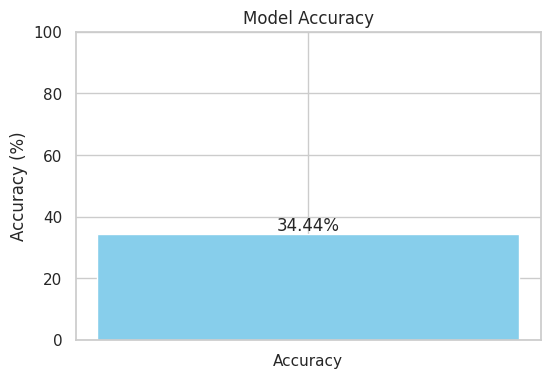

<ipython-input-36-dd9d1fb06b80>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=choices, y=values, palette="pastel")


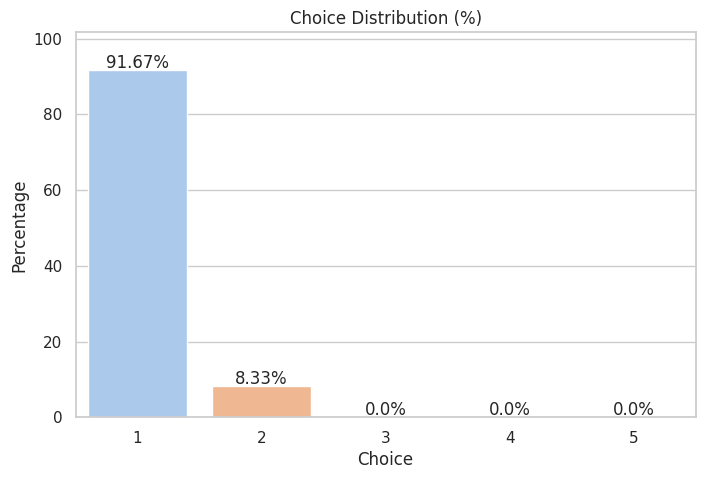

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# accuracy 출력
accuracy_percent = round(accuracy * 100, 2)

# 시각화 설정
sns.set(style="whitegrid")

# 1. Accuracy 시각화
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [accuracy_percent], color='skyblue')
plt.ylim(0, 100)
plt.title("Model Accuracy")
plt.ylabel("Accuracy (%)")
plt.text(0, accuracy_percent + 1, f"{accuracy_percent}%", ha='center')
plt.show()

# 2. Choice Distribution 시각화
plt.figure(figsize=(8, 5))
choices = list(distribution.keys())
values = list(distribution.values())
sns.barplot(x=choices, y=values, palette="pastel")
plt.title("Choice Distribution (%)")
plt.xlabel("Choice")
plt.ylabel("Percentage")
for i, val in enumerate(values):
    plt.text(i, val + 0.5, f"{val}%", ha='center')
plt.ylim(0, max(values) + 10)
plt.show()


## 데이터가 1에 unbalanced하게 있어 balanced data로 수정

In [33]:
import json
import pandas as pd
from collections import defaultdict
import random

# 라벨 별로 샘플 분류
label_groups = defaultdict(list)
for sample in json_list:
    label = int(sample["label"])
    label_groups[label].append(sample)

# 가장 적은 라벨 수 기준으로 균등하게 추출
min_count = min(len(samples) for samples in label_groups.values())

# 라벨 수를 같게 맞춘 balanced dataset 생성
balanced_json_list = []
for label, samples in label_groups.items():
    balanced_json_list.extend(random.sample(samples, min_count))

# 셔플
random.shuffle(balanced_json_list)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Balanced JSON Dataset", dataframe=pd.DataFrame(balanced_json_list))
print(len(balanced_json_list))
print(min_count)

90
18


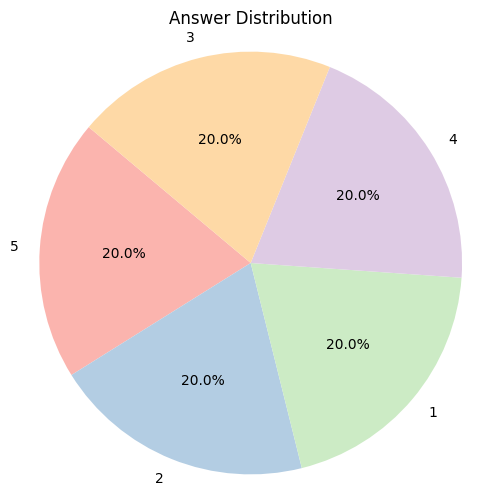

In [34]:
import matplotlib.pyplot as plt
from collections import Counter

# balanced_json_list에서 label 값만 추출
labels = [int(sample["label"]) for sample in balanced_json_list]

# 라벨별 빈도수 계산
label_counts = Counter(labels)

# 원그래프용 데이터
pie_labels = [f"{key}" for key in label_counts.keys()]
sizes = [label_counts[key] for key in label_counts.keys()]
colors = plt.cm.Pastel1.colors  # 예쁜 파스텔 색상

# 원그래프 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=pie_labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title("Answer Distribution")
plt.axis("equal")  # 원형 유지
plt.show()


Default model: Anchored Bias로 인해 1에 편향

In [45]:
import json
import torch as t
from collections import Counter
from transformer_lens import HookedTransformer

choices = [f" {i}" for i in range(1, 6)]
choice_token_ids = [model.to_tokens(c, prepend_bos=False)[0, 0].item() for c in choices]

correct = 0
results = []

# balanced data
with t.no_grad():
    for sample in balanced_json_list:
        sentence = sample["sentence"]
        label = int(sample["label"])
        tokens = model.to_tokens(sentence, prepend_bos=True)
        logits, _ = model.run_with_cache(tokens)
        probs = logits[0, -1].softmax(dim=-1)
        choice_probs = [probs[i].item() for i in choice_token_ids]
        pred = int(t.tensor(choice_probs).argmax().item()) + 1
        correct += int(pred == label)
        results.append(pred)

accuracy = correct / len(balanced_json_list)
counts = Counter(results)
distribution = {str(i): round(counts[i] / len(balanced_json_list) * 100, 2) for i in range(1, 6)}

print("Accuracy:", round(accuracy * 100, 2), "%")
print("Choice distribution:", distribution)


Accuracy: 21.11 %
Choice distribution: {'1': 93.33, '2': 6.67, '3': 0.0, '4': 0.0, '5': 0.0}


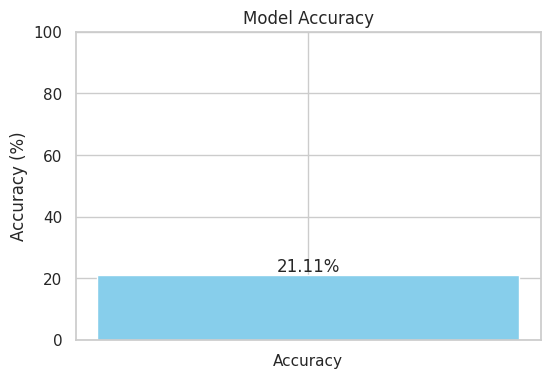

<ipython-input-46-dd9d1fb06b80>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=choices, y=values, palette="pastel")


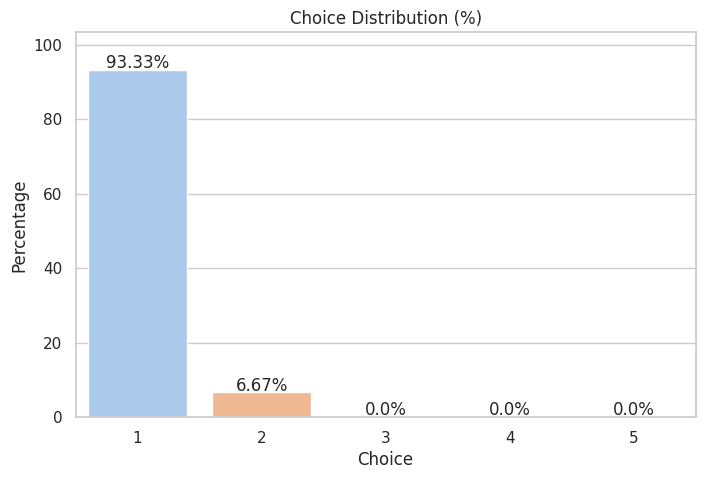

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# accuracy 출력
accuracy_percent = round(accuracy * 100, 2)

# 시각화 설정
sns.set(style="whitegrid")

# 1. Accuracy 시각화
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [accuracy_percent], color='skyblue')
plt.ylim(0, 100)
plt.title("Model Accuracy")
plt.ylabel("Accuracy (%)")
plt.text(0, accuracy_percent + 1, f"{accuracy_percent}%", ha='center')
plt.show()

# 2. Choice Distribution 시각화
plt.figure(figsize=(8, 5))
choices = list(distribution.keys())
values = list(distribution.values())
sns.barplot(x=choices, y=values, palette="pastel")
plt.title("Choice Distribution (%)")
plt.xlabel("Choice")
plt.ylabel("Percentage")
for i, val in enumerate(values):
    plt.text(i, val + 0.5, f"{val}%", ha='center')
plt.ylim(0, max(values) + 10)
plt.show()


Modified Model: anchored bias 제거

In [58]:
import json
import torch as t
from collections import Counter
# from transformer_lens import HookedTransformer

# 모델 로드
model2 = modified_model

choices = [f" {i}" for i in range(1, 6)]
choice_token_ids = [model2.to_tokens(c, prepend_bos=False)[0, 0].item() for c in choices]

correct = 0
results = []

#balanced_data
with t.no_grad():
    for sample in balanced_json_list:
        sentence = sample["sentence"]
        label = int(sample["label"])
        tokens = model2.to_tokens(sentence, prepend_bos=True)
        logits, _ = model2.run_with_cache(tokens)
        probs = logits[0, -1].softmax(dim=-1)
        choice_probs = [probs[i].item() for i in choice_token_ids]
        pred = int(t.tensor(choice_probs).argmax().item()) + 1
        correct += int(pred == label)
        results.append(pred)

accuracy2 = correct / len(balanced_json_list)
counts = Counter(results)
distribution2 = {str(i): round(counts[i] / len(balanced_json_list) * 100, 2) for i in range(1, 6)}

print("Accuracy:", round(accuracy2 * 100, 2), "%")
print("Choice distribution:", distribution2)


Accuracy: 26.67 %
Choice distribution: {'1': 8.89, '2': 21.11, '3': 17.78, '4': 20.0, '5': 32.22}


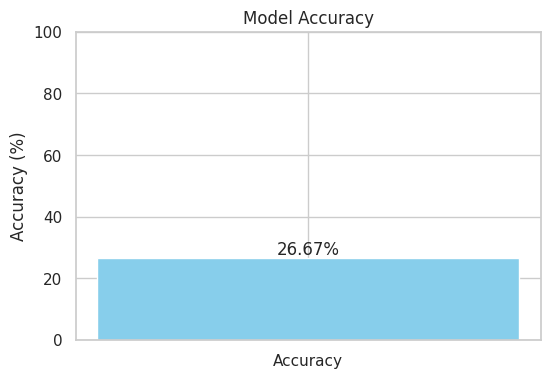

<ipython-input-59-e2af94e430c5>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=choices, y=values, palette="pastel")


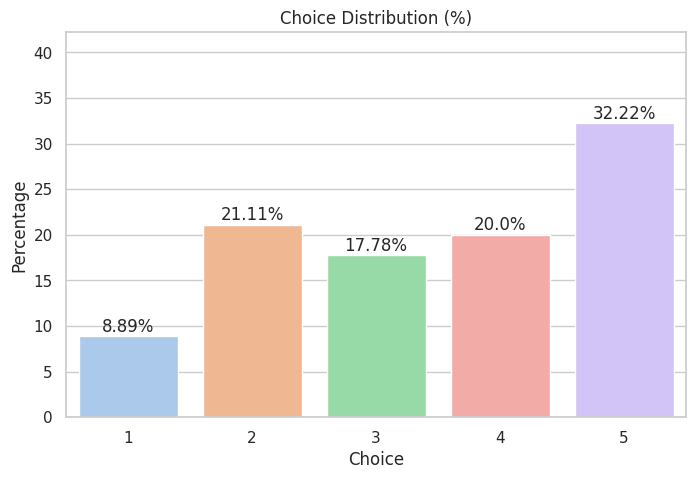

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# accuracy 출력
accuracy_percent = round(accuracy2 * 100, 2)

# 시각화 설정
sns.set(style="whitegrid")

# 1. Accuracy 시각화
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [accuracy_percent], color='skyblue')
plt.ylim(0, 100)
plt.title("Model Accuracy")
plt.ylabel("Accuracy (%)")
plt.text(0, accuracy_percent + 1, f"{accuracy_percent}%", ha='center')
plt.show()

# 2. Choice Distribution 시각화
plt.figure(figsize=(8, 5))
choices = list(distribution2.keys())
values = list(distribution2.values())
sns.barplot(x=choices, y=values, palette="pastel")
plt.title("Choice Distribution (%)")
plt.xlabel("Choice")
plt.ylabel("Percentage")
for i, val in enumerate(values):
    plt.text(i, val + 0.5, f"{val}%", ha='center')
plt.ylim(0, max(values) + 10)
plt.show()
